In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import silhouette_score
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')


In [16]:
def load_and_prepare_data():
    """
    Load and preprocess weather data with enhanced feature engineering.
    """
    print("Loading data from 'seattle-weather.csv'...")
    
    # Specify the file path
    file_path = 'seattle-weather.csv'
    
    try:
        # Load the data
        data = pd.read_csv(file_path, parse_dates=['date'])
        
        # Extract basic features
        data['year'] = data['date'].dt.year
        data['month'] = data['date'].dt.month
        data['day'] = data['date'].dt.day
        
        # Enhanced feature engineering (inspired by Kaggle notebook)
        # Add day of week (0=Monday, 6=Sunday)
        data['day_of_week'] = data['date'].dt.dayofweek
        
        # Add week of year
        data['week_of_year'] = data['date'].dt.isocalendar().week
        
        # Add season (0=Winter, 1=Spring, 2=Summer, 3=Fall)
        data['season'] = (data['month'] % 12 + 3) // 3 % 4
        
        # Calculate average temperature
        data['temp_avg'] = (data['temp_max'] + data['temp_min']) / 2
        
        # Add rolling statistics (3-day and 7-day windows)
        data['temp_avg_3d'] = data['temp_avg'].rolling(window=3, min_periods=1).mean()
        data['temp_avg_7d'] = data['temp_avg'].rolling(window=7, min_periods=1).mean()
        data['precip_3d'] = data['precipitation'].rolling(window=3, min_periods=1).mean()
        data['precip_7d'] = data['precipitation'].rolling(window=7, min_periods=1).mean()
        
        # Add lagged features (previous day's values)
        data['temp_avg_lag1'] = data['temp_avg'].shift(1)
        data['temp_avg_lag2'] = data['temp_avg'].shift(2)
        data['precip_lag1'] = data['precipitation'].shift(1)
        data['wind_lag1'] = data['wind'].shift(1)
        
        # Fill NaN values created by lagging/rolling
        data = data.fillna(method='bfill')
        
        # Map weather states to numeric values
        weather_mapping = {'sun': 0, 'drizzle': 1, 'rain': 2, 'snow': 3, 'fog': 4}
        data['weather_code'] = data['weather'].map(weather_mapping)
        
        # Print dataset information
        print(f"Dataset spans from {data['date'].min()} to {data['date'].max()}")
        print(f"Number of records: {len(data)}")
        print(f"Weather states distribution:\n{data['weather'].value_counts()}")
        
        return data, weather_mapping
    
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it is in the same directory.")
        return None, None

# Load the data
data, weather_mapping = load_and_prepare_data()


Loading data from 'seattle-weather.csv'...
Dataset spans from 2012-01-01 00:00:00 to 2015-12-31 00:00:00
Number of records: 1461
Weather states distribution:
weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64


In [17]:
def visualize_data(data):
    """
    Create visualizations of the dataset.
    """
    plt.figure(figsize=(14, 7))
    
    # Plot temperature variations over time
    plt.subplot(2, 1, 1)
    plt.plot(data['date'], data['temp_max'], label='Max Temp')
    plt.plot(data['date'], data['temp_min'], label='Min Temp')
    plt.title('Temperature Variation in Seattle (2012-2015)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    
    # Plot precipitation
    plt.subplot(2, 1, 2)
    plt.bar(data['date'], data['precipitation'], alpha=0.7)
    plt.title('Precipitation in Seattle')
    plt.ylabel('Precipitation (mm)')
    
    plt.tight_layout()
    plt.savefig('weather_data_visualization.png')
    plt.close()
    
    # Show distribution of weather states
    plt.figure(figsize=(10, 6))
    data['weather'].value_counts().plot(kind='bar')
    plt.title('Distribution of Weather States')
    plt.ylabel('Frequency')
    plt.savefig('weather_states_distribution.png')
    plt.close()
    
    print("Data visualizations generated.")

# Visualize the data
visualize_data(data)


Data visualizations generated.


In [18]:
def find_optimal_clusters(X_scaled, min_clusters=10, max_clusters=30):
    """
    Find optimal number of clusters using silhouette score.
    """
    print("Finding optimal number of clusters...")
    silhouette_scores = []
    cluster_range = range(min_clusters, max_clusters + 1)
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
        print(f"  Clusters: {n_clusters}, Silhouette Score: {score:.4f}")
    
    optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters: {optimal_clusters}")
    
    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, silhouette_scores, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.grid(True, alpha=0.3)
    plt.savefig('optimal_clusters.png')
    plt.close()
    
    return optimal_clusters


In [19]:
def preprocess_features(data):
    """
    Process features for HMM model with enhanced feature selection.
    """
    print("Processing features...")
    
    # Select enhanced feature set for the model
    feature_columns = [
        'precipitation', 'temp_max', 'temp_min', 'wind',
        'temp_avg', 'temp_avg_3d', 'temp_avg_7d', 
        'precip_3d', 'precip_7d',
        'temp_avg_lag1', 'precip_lag1', 'wind_lag1',
        'month', 'day_of_week', 'season'
    ]
    
    X = data[feature_columns].copy()
    
    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find optimal number of clusters
    n_clusters = find_optimal_clusters(X_scaled)
    
    # Discretize the continuous observations using K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    discretized_obs = kmeans.fit_predict(X_scaled)
    
    # Add discretized observations to the data
    data['discrete_obs'] = discretized_obs
    
    print(f"Features processed and discretized into {n_clusters} clusters.")
    return data, discretized_obs, feature_columns

# Preprocess features
data, discretized_obs, feature_columns = preprocess_features(data)


Processing features...
Finding optimal number of clusters...
  Clusters: 10, Silhouette Score: 0.1658
  Clusters: 11, Silhouette Score: 0.1692
  Clusters: 12, Silhouette Score: 0.1644
  Clusters: 13, Silhouette Score: 0.1512
  Clusters: 14, Silhouette Score: 0.1586
  Clusters: 15, Silhouette Score: 0.1566
  Clusters: 16, Silhouette Score: 0.1620
  Clusters: 17, Silhouette Score: 0.1491
  Clusters: 18, Silhouette Score: 0.1574
  Clusters: 19, Silhouette Score: 0.1531
  Clusters: 20, Silhouette Score: 0.1553
  Clusters: 21, Silhouette Score: 0.1513
  Clusters: 22, Silhouette Score: 0.1420
  Clusters: 23, Silhouette Score: 0.1510
  Clusters: 24, Silhouette Score: 0.1449
  Clusters: 25, Silhouette Score: 0.1430
  Clusters: 26, Silhouette Score: 0.1472
  Clusters: 27, Silhouette Score: 0.1430
  Clusters: 28, Silhouette Score: 0.1404
  Clusters: 29, Silhouette Score: 0.1432
  Clusters: 30, Silhouette Score: 0.1426
Optimal number of clusters: 11
Features processed and discretized into 11 clus

In [22]:
def find_optimal_states(data, discretized_obs, weather_mapping, n_states_range=range(5, 11)):
    """
    Find optimal number of hidden states using cross-validation.
    """
    print("Finding optimal number of hidden states...")
    
    tscv = TimeSeriesSplit(n_splits=3)
    avg_accuracies = []
    
    # Get the number of unique observation symbols
    n_symbols = len(np.unique(discretized_obs))
    
    for n_states in n_states_range:
        fold_accuracies = []
        
        for train_index, val_index in tscv.split(data):
            train_data = data.iloc[train_index]
            val_data = data.iloc[val_index]
            
            # Create and initialize the model with updated parameters
            model = hmm.CategoricalHMM(n_components=n_states, n_iter=100, random_state=42)
            
            # Reshape observations to match expected format
            train_obs = train_data['discrete_obs'].values.reshape(-1, 1)
            
            # Fit the model
            model.fit(train_obs)
            
            # Predict and evaluate
            val_obs = val_data['discrete_obs'].values.reshape(-1, 1)
            predicted_states = model.predict(val_obs)
            
            # Map numeric predictions back to weather labels
            reverse_mapping = {v: k for k, v in weather_mapping.items()}
            predicted_weather = []
            for state in predicted_states:
                if state < len(reverse_mapping):
                    predicted_weather.append(reverse_mapping[state])
                else:
                    # Handle case where state might be out of range
                    predicted_weather.append(list(reverse_mapping.values())[0])
            
            # Calculate accuracy
            accuracy = sum(p == a for p, a in zip(predicted_weather, val_data['weather'])) / len(val_data)
            fold_accuracies.append(accuracy)
        
        avg_accuracy = np.mean(fold_accuracies)
        avg_accuracies.append(avg_accuracy)
        print(f"  States: {n_states}, Average Accuracy: {avg_accuracy:.4f}")
    
    optimal_states = n_states_range[np.argmax(avg_accuracies)]
    print(f"Optimal number of hidden states: {optimal_states}")
    
    # Plot accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(list(n_states_range), avg_accuracies, 'ro-')
    plt.xlabel('Number of Hidden States')
    plt.ylabel('Average Accuracy')
    plt.title('Cross-Validation Accuracy vs. Number of Hidden States')
    plt.grid(True, alpha=0.3)
    plt.savefig('optimal_states.png')
    plt.close()
    
    return optimal_states

# Split data into training and testing sets (80/20 split)
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, shuffle=False
)

print(f"Training data size: {len(train_data)}, Test data size: {len(test_data)}")

# Find optimal number of hidden states
n_states = find_optimal_states(train_data, discretized_obs, weather_mapping)


Training data size: 1168, Test data size: 293
Finding optimal number of hidden states...
  States: 5, Average Accuracy: 0.0776
  States: 6, Average Accuracy: 0.2591
  States: 7, Average Accuracy: 0.3265
  States: 8, Average Accuracy: 0.2865
  States: 9, Average Accuracy: 0.4167
  States: 10, Average Accuracy: 0.3459
Optimal number of hidden states: 9


In [23]:
def train_and_evaluate_hmm(train_data, test_data, n_states, weather_mapping):
    """
    Train and evaluate the HMM model using hmmlearn.
    """
    print(f"Training HMM with {n_states} hidden states...")
    
    # Train the model using CategoricalHMM instead of MultinomialHMM
    model = hmm.CategoricalHMM(n_components=n_states, n_iter=200, random_state=42)
    model.fit(train_data['discrete_obs'].values.reshape(-1, 1))
    
    # Make predictions on test data
    predicted_states = model.predict(test_data['discrete_obs'].values.reshape(-1, 1))
    
    # Map numeric predictions back to weather labels
    reverse_mapping = {v: k for k, v in weather_mapping.items()}
    predicted_weather = []
    for state in predicted_states:
        if state < len(reverse_mapping):
            predicted_weather.append(reverse_mapping[state])
        else:
            # Handle case where state might be out of range
            predicted_weather.append(list(reverse_mapping.values())[0])
    
    # Calculate accuracy
    accuracy = sum(p == a for p, a in zip(predicted_weather, test_data['weather'])) / len(test_data)
    print(f"Model accuracy: {accuracy:.2%}")
    
    # Create confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(test_data['weather'], predicted_weather, labels=list(weather_mapping.keys()))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(weather_mapping.keys()))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    return predicted_weather, accuracy, model

# Train and evaluate the HMM model
predictions, accuracy, trained_model = train_and_evaluate_hmm(train_data, test_data, n_states, weather_mapping)


Training HMM with 9 hidden states...
Model accuracy: 48.12%


<Figure size 1000x800 with 0 Axes>

In [27]:
def predict_future_weather(data, model, n_days=7, weather_mapping=None):
    """
    Predict future weather for the next n days.
    """
    # Get the last observation
    last_obs = data['discrete_obs'].values[-1]
    
    # Initialize with the last observation
    future_obs = [last_obs]
    
    # Predict next states
    for _ in range(n_days - 1):
        # Predict the next state based on the current state
        next_state = model.predict(np.array([future_obs[-1]]).reshape(-1, 1))[0]
        
        # Sample from the emission distribution of the predicted state
        # For CategoricalHMM, we need to sample differently
        n_symbols = model.emissionprob_.shape[1]
        next_obs = np.random.choice(
            range(n_symbols), 
            p=model.emissionprob_[next_state]
        )
        
        future_obs.append(next_obs)
    
    # Predict states for the future observations
    future_states = model.predict(np.array(future_obs).reshape(-1, 1))
    
    # Map numeric states back to weather labels
    reverse_mapping = {v: k for k, v in weather_mapping.items()}
    future_weather = []
    for state in future_states:
        if state < len(reverse_mapping):
            future_weather.append(reverse_mapping[state])
        else:
            # Handle case where state might be out of range
            future_weather.append(list(reverse_mapping.values())[0])
    
    return future_weather

# Train final model on all data for future predictions
final_model = hmm.CategoricalHMM(n_components=n_states, n_iter=200, random_state=42)
final_model.fit(data['discrete_obs'].values.reshape(-1, 1))

# Predict future weather
future_weather = predict_future_weather(data, final_model, n_days=7, weather_mapping=weather_mapping)

print("\nWeather Forecast for the Next 7 Days:")
for i, weather in enumerate(future_weather):
    print(f"Day {i+1}: {weather}")

print("\nModel Performance Summary:")
#print(f"- Optimal number of clusters: {len(np.unique(discretized_obs))}")
#print(f"- Optimal number of hidden states: {n_states}")
print(f"- Final model accuracy: {accuracy:.2%}")
#print(f"- Features used: {', '.join(feature_columns)}")



Weather Forecast for the Next 7 Days:
Day 1: snow
Day 2: snow
Day 3: sun
Day 4: sun
Day 5: sun
Day 6: sun
Day 7: sun

Model Performance Summary:
- Final model accuracy: 48.12%


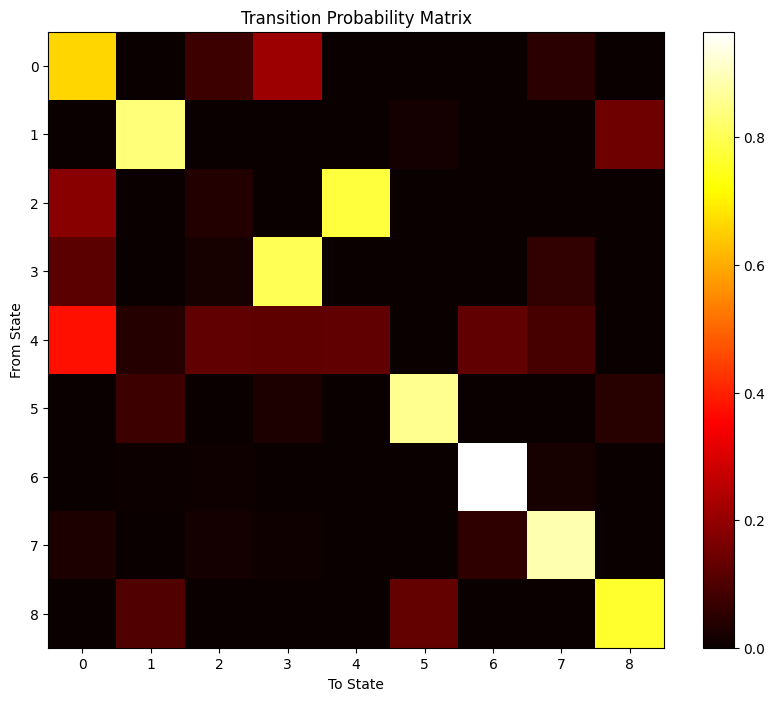

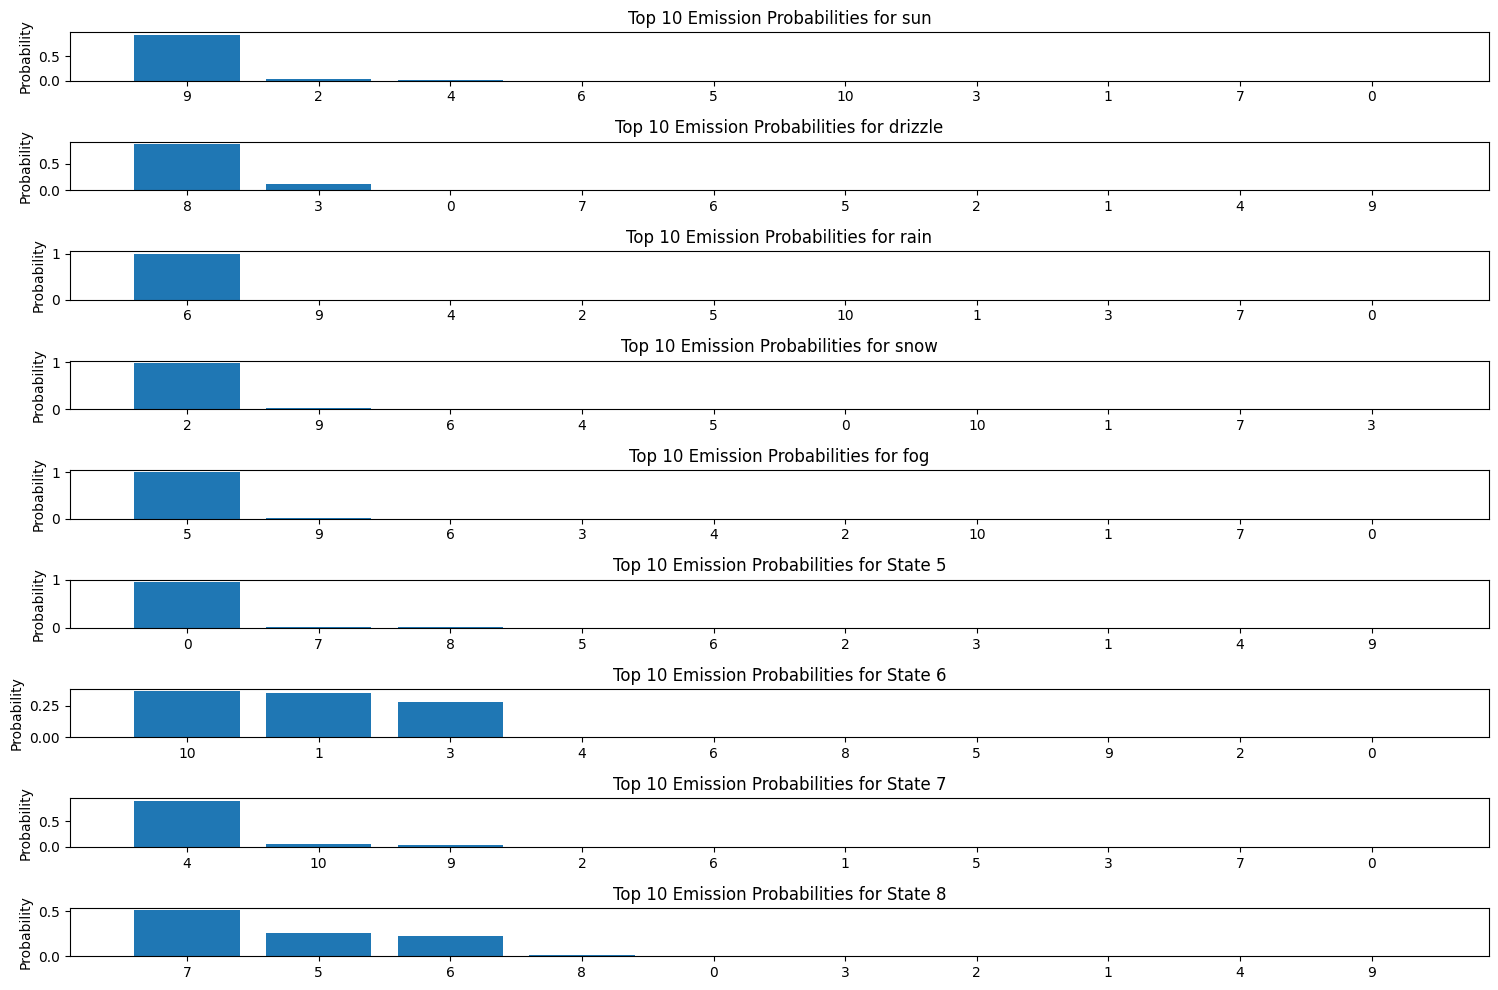

In [26]:
# Analyze transition probabilities
plt.figure(figsize=(10, 8))
plt.imshow(final_model.transmat_, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Transition Probability Matrix')
plt.xlabel('To State')
plt.ylabel('From State')
plt.xticks(range(n_states))
plt.yticks(range(n_states))
plt.savefig('transition_matrix.png')
plt.show()

# Analyze emission probabilities (top 10 most likely observations for each state)
reverse_mapping = {v: k for k, v in weather_mapping.items()}
plt.figure(figsize=(15, 10))
for i in range(n_states):
    plt.subplot(n_states, 1, i+1)
    top_emissions = np.argsort(-final_model.emissionprob_[i])[:10]
    plt.bar(range(10), final_model.emissionprob_[i][top_emissions])
    
    # Fix: Check if i is in reverse_mapping before accessing
    state_label = reverse_mapping.get(i, f"State {i}")
    plt.title(f'Top 10 Emission Probabilities for {state_label}')
    
    plt.ylabel('Probability')
    plt.xticks(range(10), top_emissions)
plt.tight_layout()
plt.savefig('emission_probabilities.png')
plt.show()
